# IFQ720 Assignment 2

For this assignment, you will use a dataset that contains records for 704 episodes of Star Trek aired between 1966 and 2005 to answer the following 6 questions

In [46]:
# import libaries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f, bartlett, levene
from statsmodels.formula.api import ols, logit
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Importing Plotnine for additional visualizations
from plotnine import (
    ggplot, aes, geom_boxplot, geom_histogram, geom_point,
    geom_qq, geom_qq_line, ggtitle, geom_smooth
)

#loading data files 
file_path = 'data/star_trek_data(1).csv'
original_df = pd.read_csv(file_path)

In [47]:
# Creating a copy of the data

df_copy = original_df.copy()

# Creating a filtered copy by extracting the year from 'Air.date'
# Assuming 'Air.date' is a datetime column or converting it to datetime
df_copy['Air.date'] = pd.to_datetime(df_copy['Air.date'], errors='coerce')

# Filter the DataFrame for years between 1966 and 2005
filtered_df = df_copy[(df_copy['Air.date'].dt.year >= 1966) & (df_copy['Air.date'].dt.year <= 2005)]

filtered_star_trek_data = filtered_df.iloc[:, 1:]
filtered_star_trek_data.reset_index(drop=True, inplace=True)
filtered_star_trek_data.index += 1

# Save the filtered DataFrame to a CSV file

filtered_star_trek_data.to_csv('data/filtered_star_trek_data.csv', index=False)

In [48]:
# Renaming columns for easier reference
filtered_star_trek_data.rename(columns={'IMDB.Ranking': 'IMDB_Rating'}, inplace=True)

# Dropping unnecessary columns and handling missing values
filtered_star_trek_data = filtered_star_trek_data.dropna(subset=['IMDB_Rating', 'Series'])

In [49]:
# First, check if 'IMDB Rating' is numeric, otherwise convert it
filtered_star_trek_data['IMDB Rating'] = pd.to_numeric(filtered_star_trek_data['IMDB_Rating'], errors='coerce')

# Check for missing values and drop them
filtered_star_trek_data = filtered_star_trek_data.dropna(subset=['IMDB_Rating', 'Series'])


## Question 1

Perform a one-way ANOVA to examine if there is any difference between the average IMDB Ranking for each series.

1. What are the assumptions when using analysis of variance? Do these data appear follow those assumptions. Perform an analysis of the residuals to test this and report your results.


    There are a couple assumptions when analysising variance ... 
    
    1. Normality - The residuals follow a normal distribution 
    2. Homogeneity of variance - The spread across the residuals should be similar
    3. Linear relationship is reasonable 

In [50]:
# Perform one-way ANOVA using statsmodels
model = ols('IMDB_Rating ~ C(Series)', data=filtered_star_trek_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
C(Series),1211.113581,4.0,516.864209,0.0
Residual,53646.861513,91579.0,NaN,NaN


In [51]:
# Create a DataFrame to store residuals and fitted values
df_fit = pd.DataFrame({
    'residuals_2': model.resid,
    'fitted_values_2': model.fittedvalues
})


# Plot 1: Histogram of Residuals using ggplot
plot1 = (ggplot(df_fit, aes(x='residuals_2')) +
         geom_histogram(bins=21, fill='grey', alpha=0.7) +
         ggtitle("Histogram of Residuals")).draw()


# Plot 2: Residuals vs Fitted Values using ggplot
plot2 = (ggplot(df_fit, aes(x='fitted_values_2', y='residuals_2')) +
         geom_point(color='grey', alpha=0.5) +
         ggtitle("Residuals vs Fitted Values")).draw()

# Plot 3: Q-Q Plot of Residuals using ggplot
plot3 = (ggplot(df_fit, aes(sample='residuals_2')) +
         geom_qq(color='grey', alpha=0.5) +
         geom_qq_line() +
         ggtitle("Q-Q Plot of Residuals")).draw()


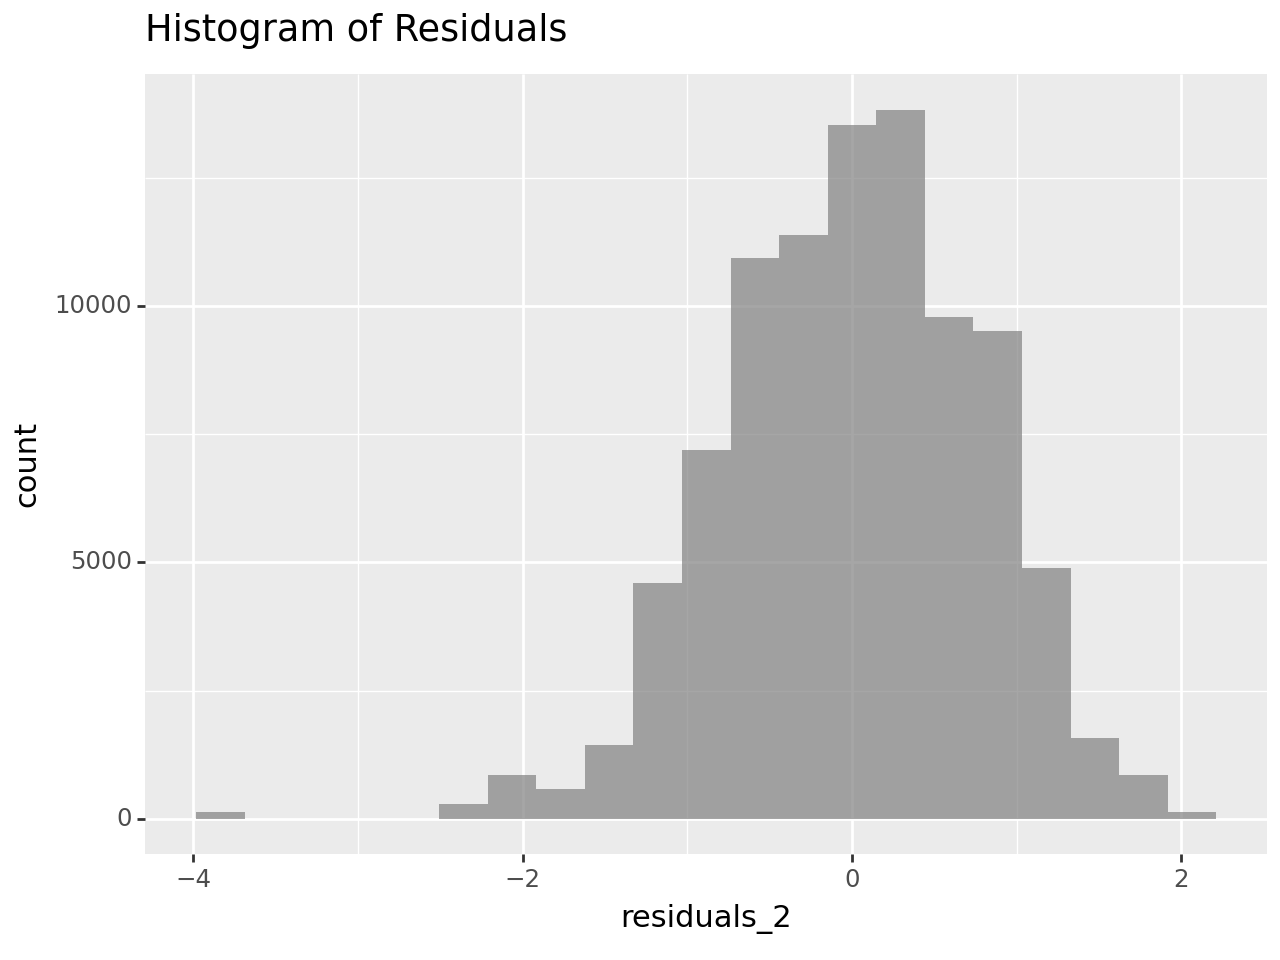

In [52]:
plot1

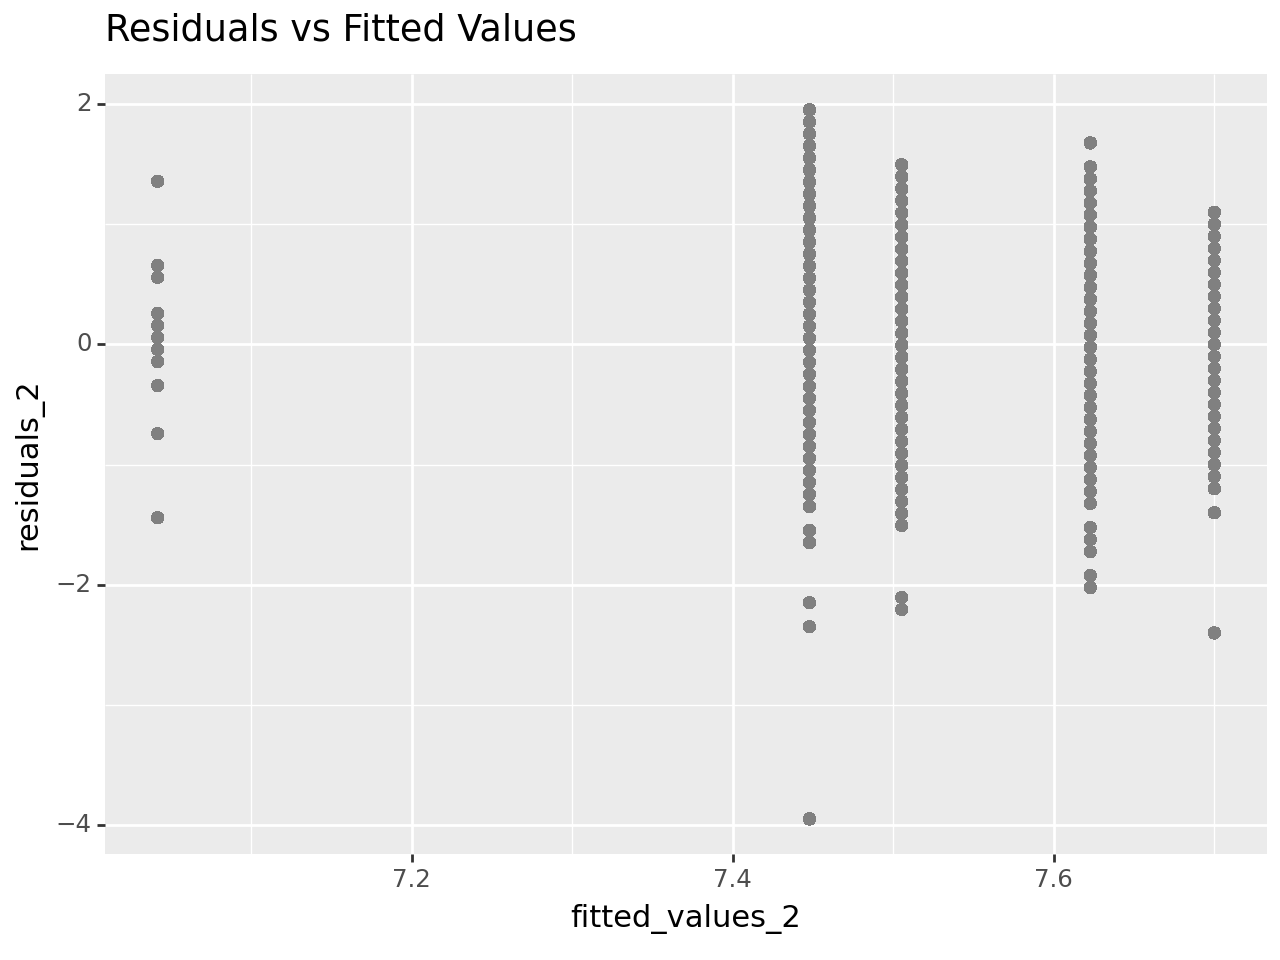

In [53]:
plot2

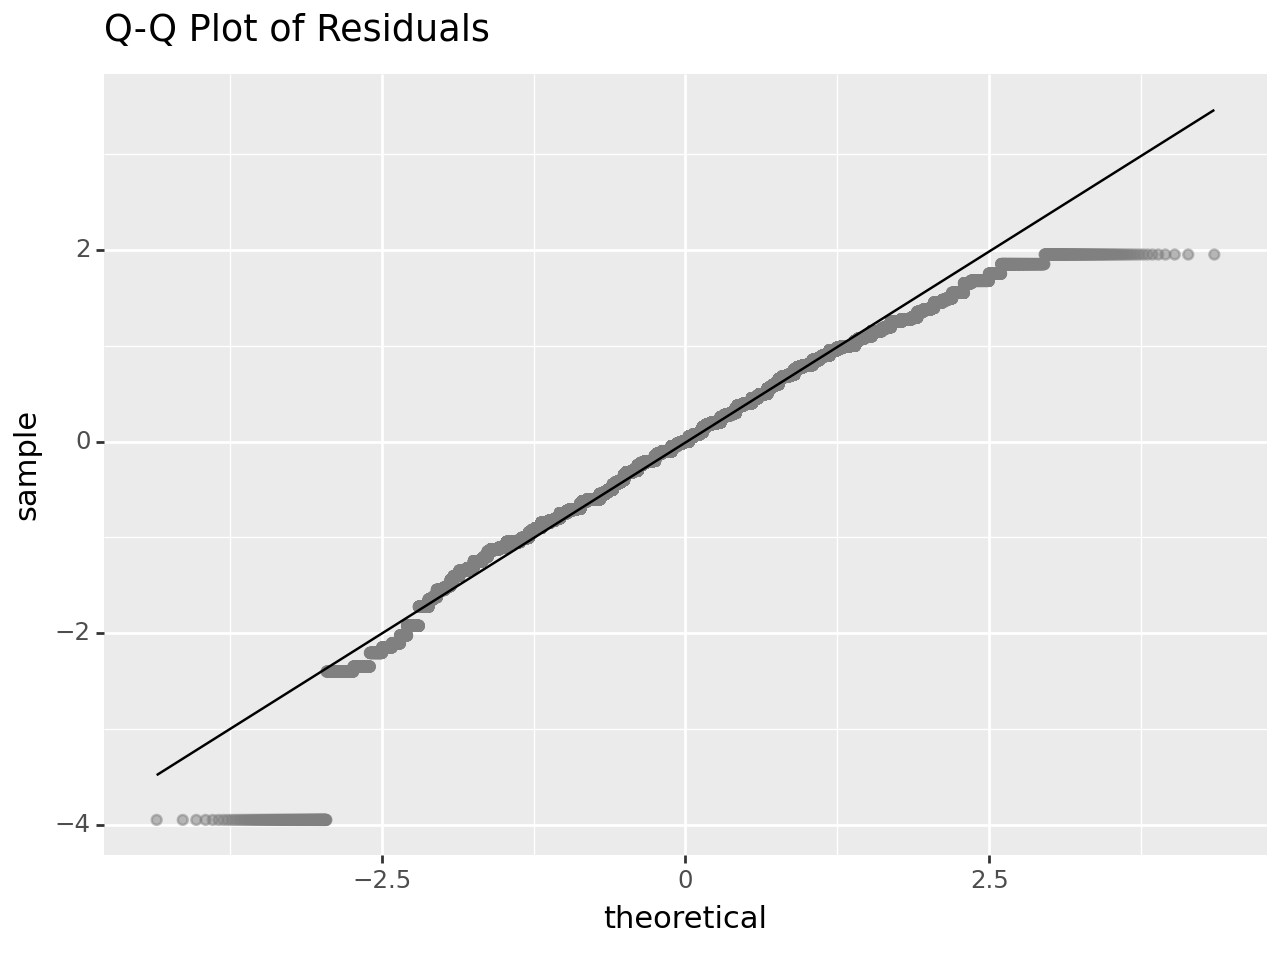

In [54]:
plot3

2. Report the results of the ANOVA and use Tukey’s Honest Significant Difference to determine which series is has the highest average IMDB Ranking.

In [55]:
tukey = pairwise_tukeyhsd(endog=filtered_star_trek_data['IMDB_Rating'],  # Dependent variable
                          groups=filtered_star_trek_data['Series'],      # Independent variable (grouping by Series)
                          alpha=0.05)                                    # Significance level
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   DS9    ENT   0.0773   0.0  0.0553  0.0992   True
   DS9    TNG   -0.175   0.0 -0.1935 -0.1565   True
   DS9    TOS  -0.5811   0.0  -0.633 -0.5292   True
   DS9    VOY  -0.1175   0.0 -0.1361 -0.0988   True
   ENT    TNG  -0.2522   0.0 -0.2741 -0.2304   True
   ENT    TOS  -0.6583   0.0 -0.7115 -0.6051   True
   ENT    VOY  -0.1948   0.0 -0.2168 -0.1727   True
   TNG    TOS  -0.4061   0.0  -0.458 -0.3542   True
   TNG    VOY   0.0575   0.0  0.0389  0.0761   True
   TOS    VOY   0.4636   0.0  0.4116  0.5155   True
---------------------------------------------------


Answers ...


1. The residuals generally meet the assumptions for ANOVA, with only minor deviations from normality and slight variations in variance between groups. These issues don't seem significant enough to affect the overall results, but if you're concerned, you could consider using Welch's ANOVA, which is more flexible with unequal variances. The Q-Q plot shows that the residuals are mostly normal, with a few outliers, while the Residuals vs. Fitted Values plot doesn't indicate any major variance issues. Assuming the data was collected independently, the independence assumption should also hold.


2. Enterprise (ENT) has the highest average IMDB rating, with significantly higher ratings compared to TNG, TOS, and VOY.


## Question 2

Perform a two-way ANOVA to examine if there is any difference between the average IMDB Ranking for episodes written by female writers and directed by female directors.

1. Perform all the relevant diagnostics and comment on your findings.

In [56]:
# Rename columns for easy reference if needed
filtered_star_trek_data.rename(columns={'Female.Writer': 'Female_Writer', 'Female.Director': 'Female_Director'}, inplace=True)

# Convert the binary columns into categorical variables for ANOVA
filtered_star_trek_data['Female_Writer'] = filtered_star_trek_data['Female_Writer'].astype('category')
filtered_star_trek_data['Female_Director'] = filtered_star_trek_data['Female_Director'].astype('category')


In [57]:
# Perform two-way ANOVA using OLS (Ordinary Least Squares)
model = ols('IMDB_Rating ~ C(Female_Writer) + C(Female_Director) + C(Female_Writer):C(Female_Director)', 
            data=filtered_star_trek_data).fit()

# Create a DataFrame to store residuals and fitted values
df_fit2 = pd.DataFrame({
    'residuals_2': model.resid,
    'fitted_values_2': model.fittedvalues
})

# Generate the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
C(Female_Writer),222.544476,1.0,373.651977,4.395548e-83
C(Female_Director),92.425894,1.0,155.182994,1.364862e-35
C(Female_Writer):C(Female_Director),2.956229,1.0,4.963505,2.589010e-02
Residual,54544.400584,91580.0,NaN,NaN


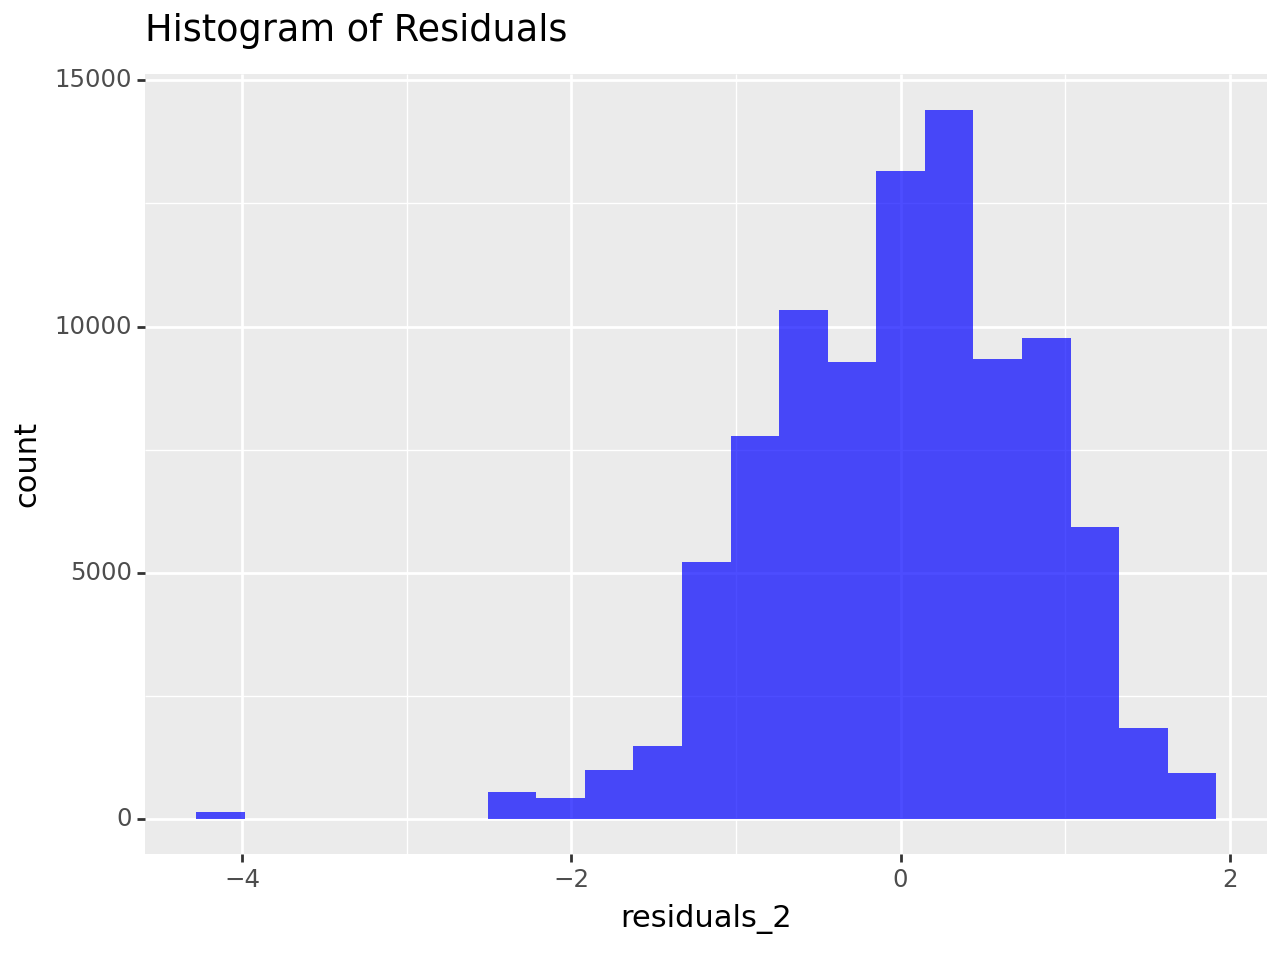

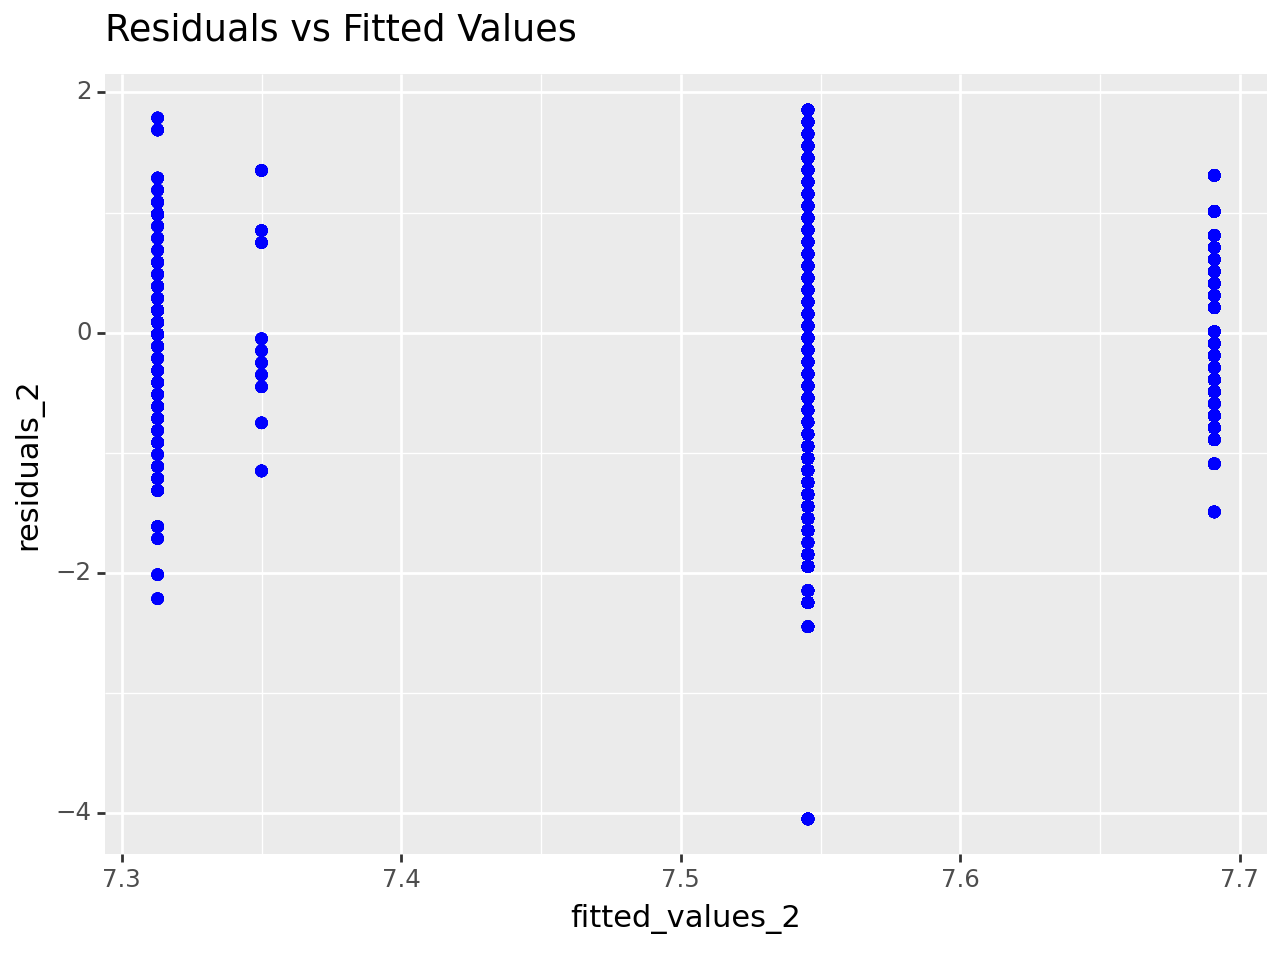

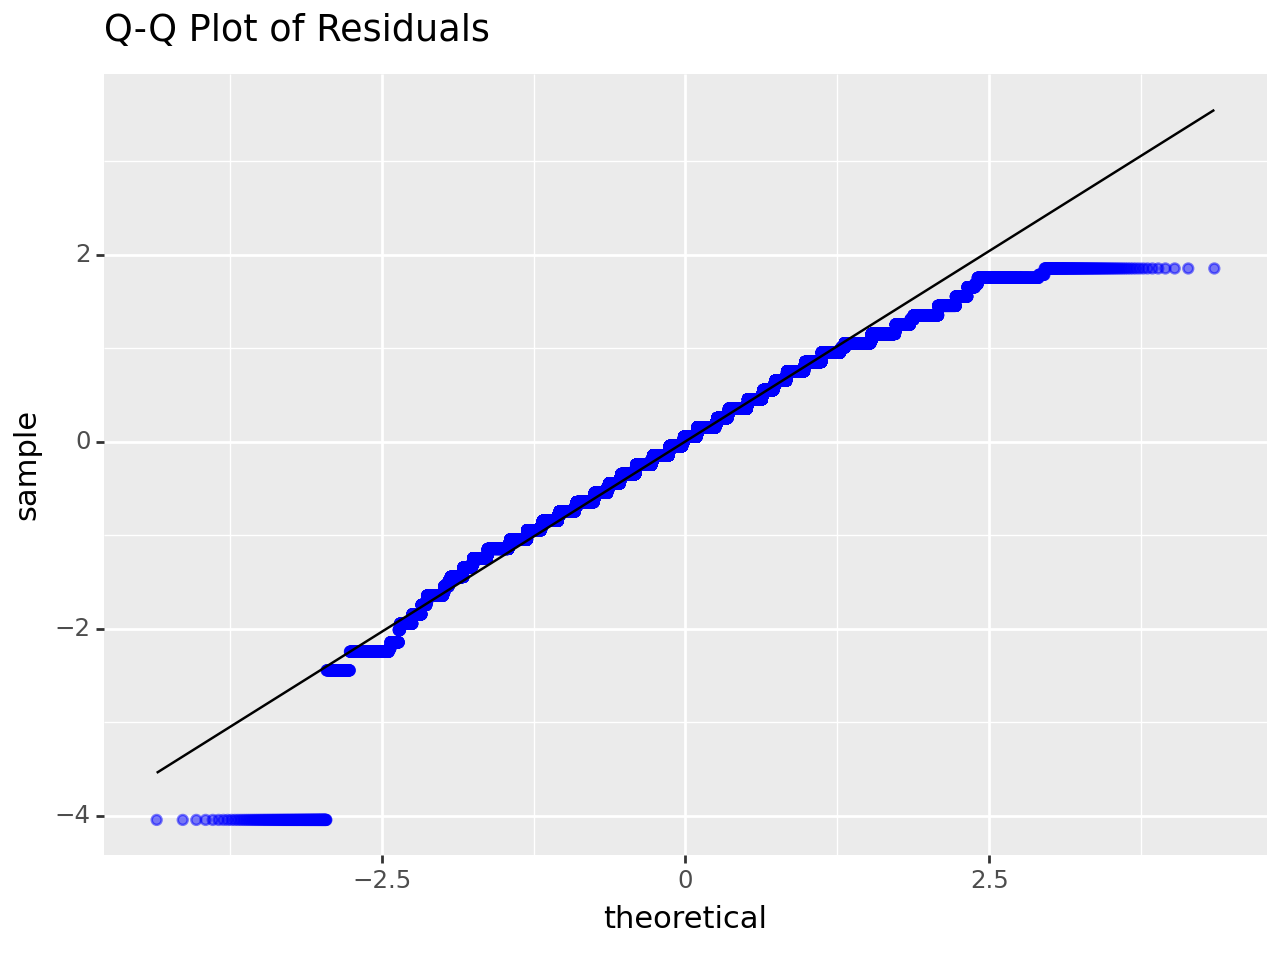

In [58]:
# Plot 1: Histogram of Residuals using ggplot
plot4 = (ggplot(df_fit2, aes(x='residuals_2')) +
         geom_histogram(bins=21, fill='blue', alpha=0.7) +
         ggtitle("Histogram of Residuals"))
print(plot4)

# Plot 2: Residuals vs Fitted Values using ggplot
plot5 = (ggplot(df_fit2, aes(x='fitted_values_2', y='residuals_2')) +
         geom_point(color='blue', alpha=0.5) +
         ggtitle("Residuals vs Fitted Values"))
print(plot5)

# Plot 3: Q-Q Plot of Residuals using ggplot
plot6 = (ggplot(df_fit2, aes(sample='residuals_2')) +
         geom_qq(color='blue', alpha=0.5) +
         geom_qq_line() +
         ggtitle("Q-Q Plot of Residuals"))
print(plot6)

Answer 

The diagnostic plots indicate that the assumptions for ANOVA may not be fully met. The histogram shows a left skew in the residuals, suggesting a violation of normality, while the residuals vs. fitted values plot displays clustering, hinting at issues with homoscedasticity. The Q-Q plot further confirms deviations from normality, particularly at the extremes, with heavy tails. Together, these findings suggest that the ANOVA results could be unreliable, and it may be necessary to explore data transformations or alternative statistical methods to address these issues.

2. Use Tukey’s Honest Significant Difference to evaluate the results. What do they mean?

In [59]:
# Perform Tukey's HSD test for IMDB ratings across combinations of Female Writer and Female Director
tukey = pairwise_tukeyhsd(endog=filtered_star_trek_data['IMDB_Rating'],
                          groups=filtered_star_trek_data['Female_Writer'].astype(str) + "-" + filtered_star_trek_data['Female_Director'].astype(str),
                          alpha=0.05)

print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1     group2   meandiff p-adj   lower   upper  reject
-------------------------------------------------------------
False-False False-True   0.1454    0.0  0.1158   0.175   True
False-False True-False  -0.2327    0.0 -0.2658 -0.1996   True
False-False  True-True  -0.1955 0.0001 -0.3125 -0.0785   True
 False-True True-False  -0.3781    0.0 -0.4214 -0.3348   True
 False-True  True-True  -0.3409    0.0 -0.4612 -0.2206   True
 True-False  True-True   0.0372   0.86 -0.0841  0.1584  False
-------------------------------------------------------------


Answer 

Episodes with female writers generally have higher IMDb ratings, no matter if there's a female director or not. Interestingly, episodes with only a female director but no female writer (False-True) tend to have lower ratings compared to other combinations. The only comparison that didn't show a big difference was between episodes with both a female writer and director (True-True) and those with just a female writer (True-False). This suggests that having a female director doesn't add much to the ratings when a female writer is already involved.

3. Now consider adding an interaction term and use Tukey’s Honest Significant Difference to evaluate the results. What do they mean?

In [60]:
# Perform two-way ANOVA with interaction term
model_interaction = ols('IMDB_Rating ~ C(Female_Writer) * C(Female_Director)', data=filtered_star_trek_data).fit()

# ANOVA table for the interaction model
anova_interaction_table = sm.stats.anova_lm(model_interaction, typ=2)
print(anova_interaction_table)

# Create a DataFrame for residuals and fitted values
df_fit_interaction = pd.DataFrame({
    'residuals_2': model_interaction.resid,
    'fitted_values_2': model_interaction.fittedvalues
})

# Perform Tukey's HSD test for the interaction term
tukey_interaction = pairwise_tukeyhsd(endog=filtered_star_trek_data['IMDB_Rating'],
                                      groups=filtered_star_trek_data['Female_Writer'].astype(str) + "-" + filtered_star_trek_data['Female_Director'].astype(str),
                                      alpha=0.05)

# Print Tukey's HSD results
print(tukey_interaction)

                                           sum_sq       df           F  \
C(Female_Writer)                       222.544476      1.0  373.651977   
C(Female_Director)                      92.425894      1.0  155.182994   
C(Female_Writer):C(Female_Director)      2.956229      1.0    4.963505   
Residual                             54544.400584  91580.0         NaN   

                                           PR(>F)  
C(Female_Writer)                     4.395548e-83  
C(Female_Director)                   1.364862e-35  
C(Female_Writer):C(Female_Director)  2.589010e-02  
Residual                                      NaN  
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1     group2   meandiff p-adj   lower   upper  reject
-------------------------------------------------------------
False-False False-True   0.1454    0.0  0.1158   0.175   True
False-False True-False  -0.2327    0.0 -0.2658 -0.1996   True
False-False  True-True  -0.1955 0.0001 -0.3125 -0.0785   Tr

Answer

Interaction Term: Helps us understand if the combination of a female writer and director has a unique effect on IMDb ratings.
Tukey’s HSD: Evaluates which specific combinations of female writer and director lead to significantly different IMDb ratings.
Interpretation: The results will indicate whether the combined influence of female writers and directors leads to higher, lower, or unchanged IMDb ratings, compared to episodes with just one or neither.

## Question 3

Have IMDB rankings changed over time? Fit a linear model to IMDB rankings with Air date as the independent variable.

1. Plot your results as a scatter plot with the fitted line.

In [61]:
# Extract the year from the 'Air.date' column
filtered_star_trek_data['Year'] = filtered_star_trek_data['Air.date'].dt.year

model = ols('IMDB_Rating ~ Year', data=filtered_star_trek_data).fit()

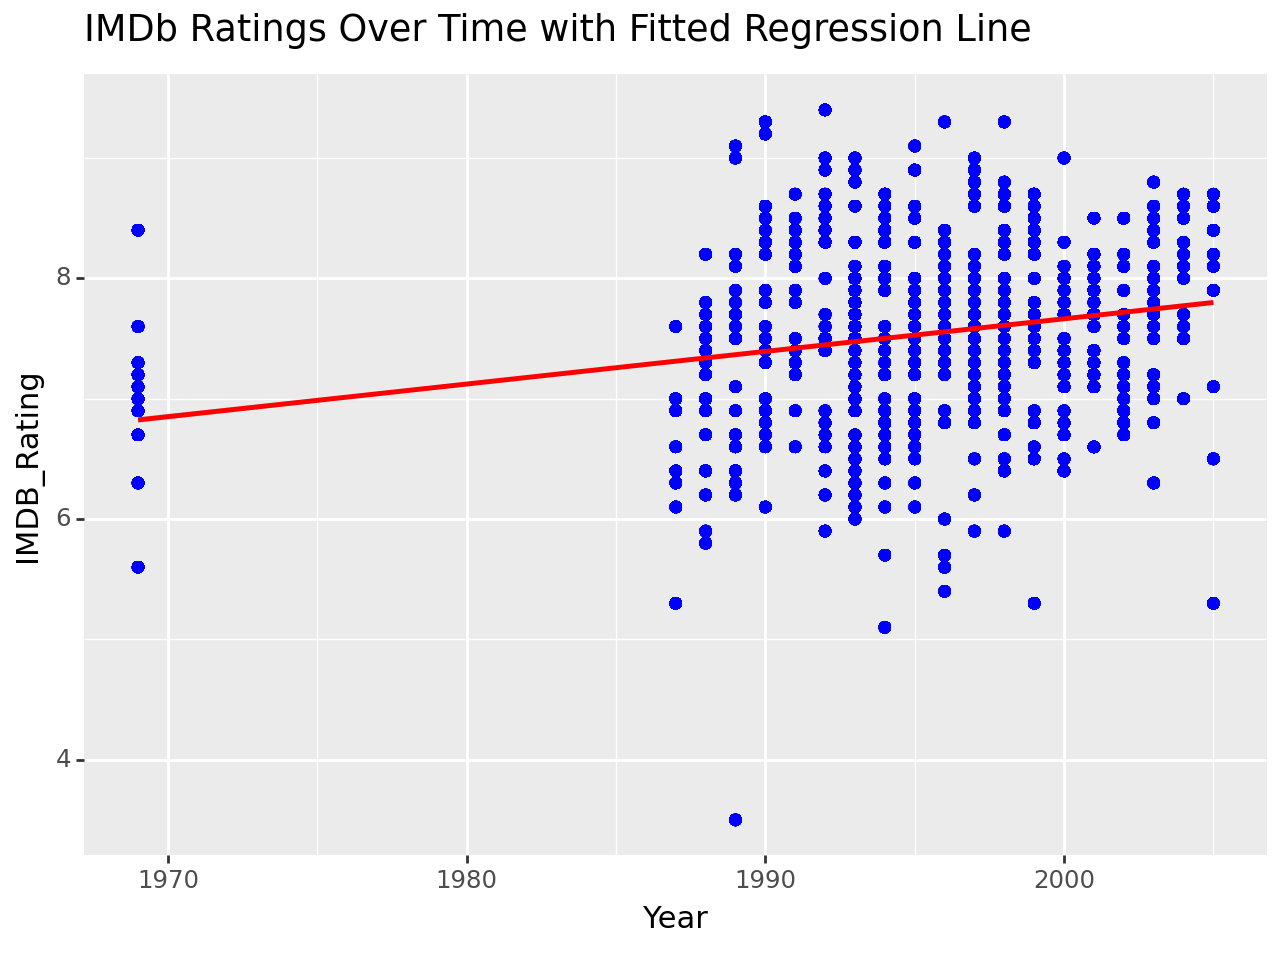

In [62]:

# Use ggplot to create a scatter plot with the fitted line (regression line)
plot = (ggplot(filtered_star_trek_data, aes(x='Year', y='IMDB_Rating')) +
        geom_point(color='blue', alpha=0.5) +  # Scatter plot for IMDb rankings
        geom_smooth(method='lm', color='red') +  # Fitted regression line
        ggtitle("IMDb Ratings Over Time with Fitted Regression Line"))

# Display the plot
print(plot)

Answer

The plot shows a slight upward trend in IMDb ratings over time, but the overall change is pretty modest. Ratings are spread out quite a bit, which means viewer opinions have varied a lot. However, since the 1980s, the ratings seem to have become more consistent, mostly hovering around the 6-8 range. There’s no major shift in ratings across the decades, but the small upward slope could point to a gradual improvement in episode quality or perhaps increasing appreciation from viewers over time.

2. Perform all the relevant diagnostics and comment on your findings.

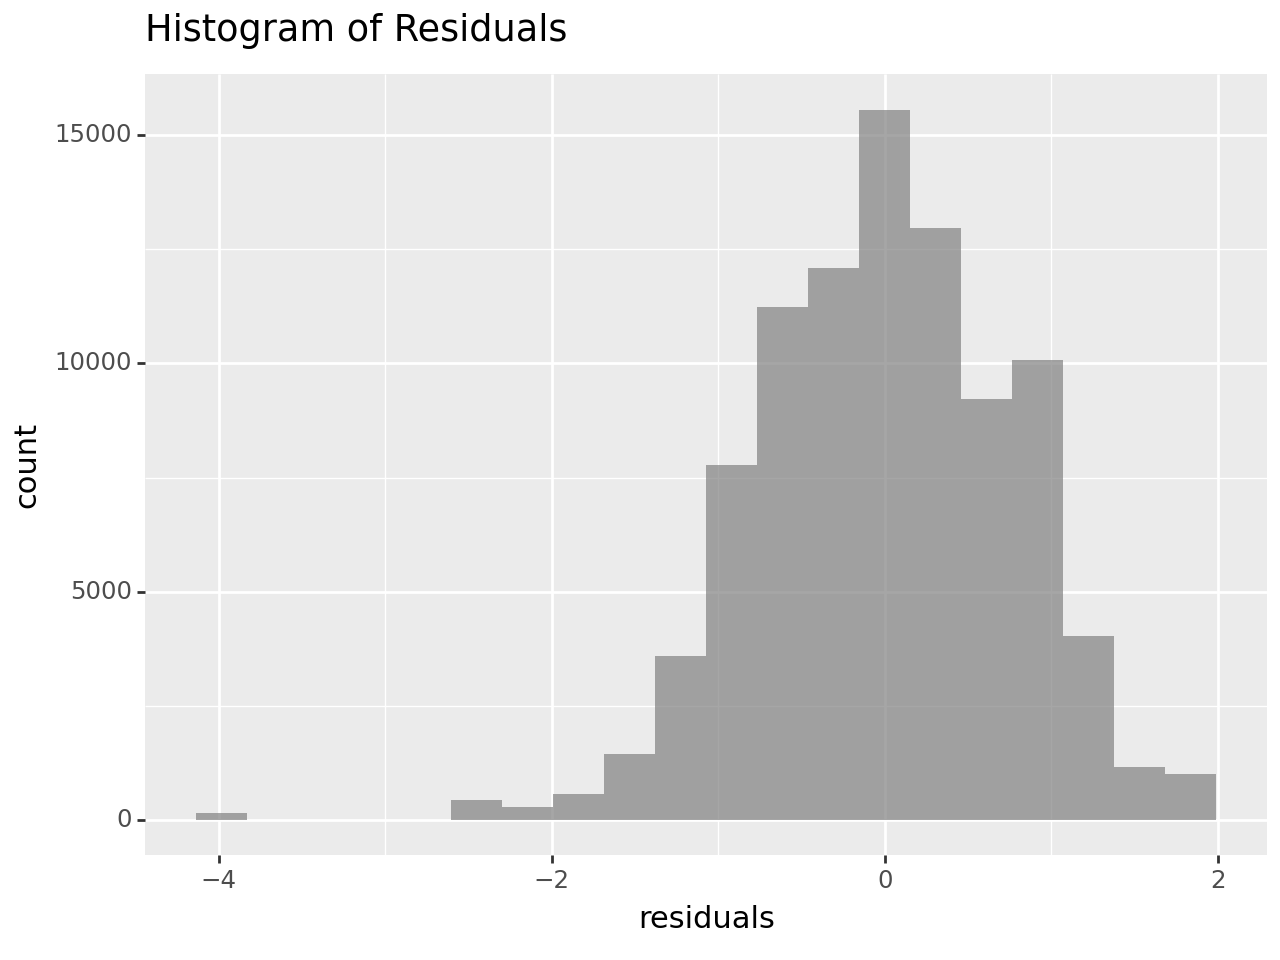

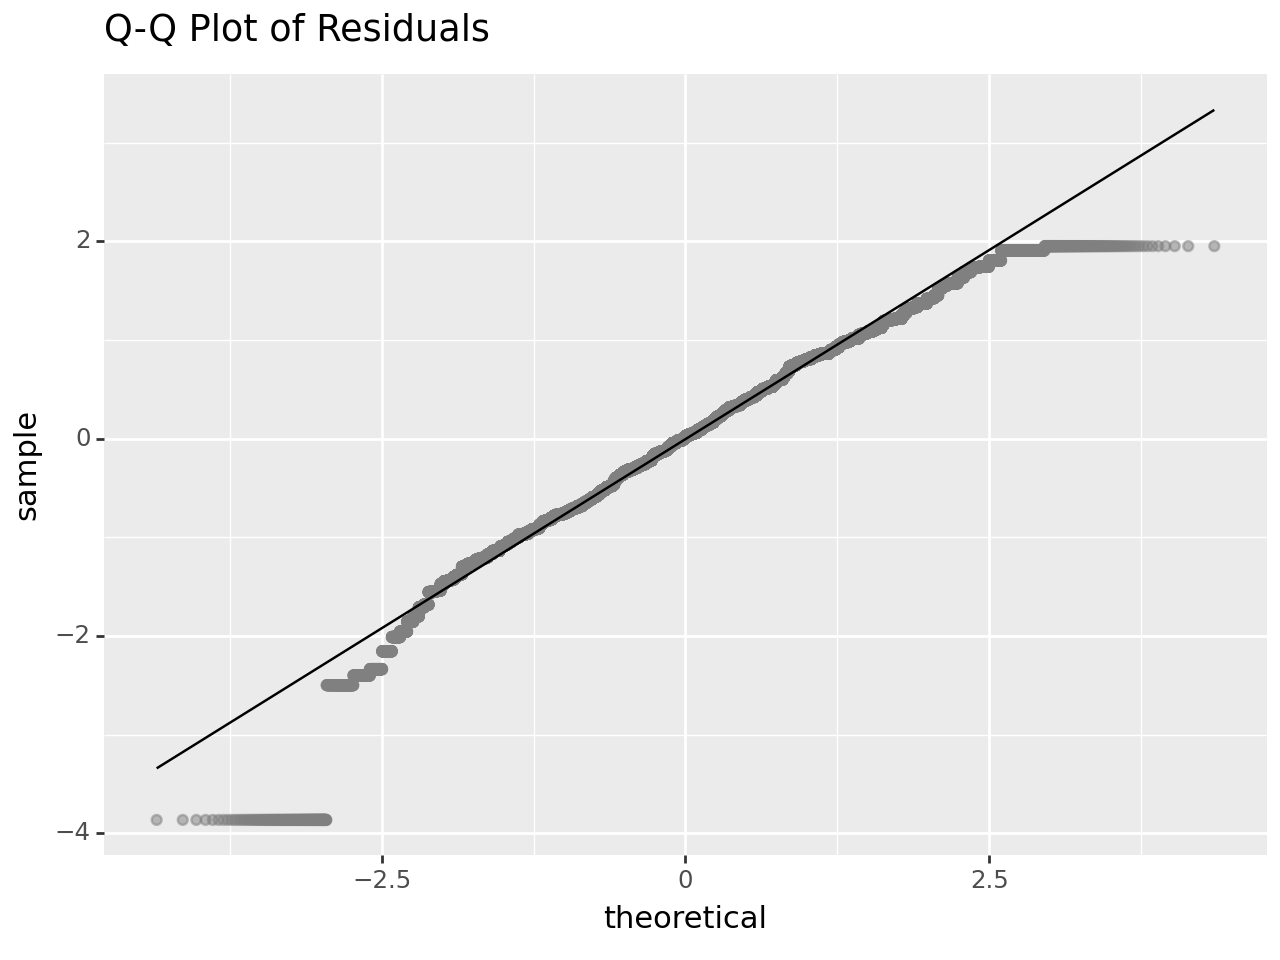

In [63]:
# Create DataFrame with residuals and fitted values
df_fit = pd.DataFrame({'residuals': model.resid, 'fitted_values': model.fittedvalues})

# Histogram of Residuals using ggplot
histogram_plot = (ggplot(df_fit, aes(x='residuals')) +
                  geom_histogram(bins=20, fill='grey', alpha=0.7) +
                  ggtitle('Histogram of Residuals'))

# Q-Q Plot using ggplot
qq_plot = (ggplot(df_fit, aes(sample='residuals')) +
           geom_qq(color='grey', alpha=0.5) +
           geom_qq_line() +
           ggtitle('Q-Q Plot of Residuals'))

# Display the plots
print(histogram_plot)
print(qq_plot)


Answer  

The residuals look mostly normal, with a bit of skew to the left. The Q-Q plot shows that most of the residuals follow a normal pattern, but there are a few outliers at the extremes. While these outliers could have a slight impact, the overall distribution seems fine and the normality assumption holds up pretty well. The model looks solid, but it might be worth checking out those outliers if they seem important.

3. Comment on your results, has the quality of episodes improved over time? What could account for this? Think about the IMDB ranking methodology, is this a 'fair' measure? Are the data biased by the data collection process?

Answer

There’s a slight upward trend in IMDb ratings over time, which could suggest that episode quality has improved, or maybe just that viewers today see things more positively. However, the change isn’t huge, and the wide range of ratings shows that people’s opinions have varied a lot over the years.

When thinking about IMDb's ranking system, it’s good to keep in mind that it’s based on user reviews, which can introduce some bias. 

Things like nostalgia, changing viewer tastes, and how relevant episodes are today could affect how people rate older versus newer episodes. Plus, people who feel really strongly about an episode, whether they loved or hated it, are more likely to leave a review, which can skew the results. Newer episodes probably get more ratings due to streaming platforms, while older episodes might have fewer, which could affect their scores too. So while IMDb ratings give us a sense of viewer opinion, they might not be the most "fair" or unbiased measure of quality.

## Question 4

Do episodes that pass the Bechdel-Wallace Test rank higher than those that don’t? Fit a two-way ANOVA for IMDB Ranking with factors Bechdel-Wallace Test and Series, include an interaction term.

1. Are the factors significant? Use Tukey’s Honest Significant Difference to test this in-depth.

In [64]:
# Rename the column 'Bechdel.Wallace.Test' to 'Bechdel_Wallace_Test' for easier use
filtered_star_trek_data = filtered_star_trek_data.rename(columns={'Bechdel.Wallace.Test': 'Bechdel_Wallace_Test'})

# Now fit the two-way ANOVA model with the interaction term
anova_model = ols('IMDB_Rating ~ C(Bechdel_Wallace_Test) * C(Series)', data=filtered_star_trek_data).fit()

# Get the ANOVA table
anova_results = sm.stats.anova_lm(anova_model, typ=2)

# Perform Tukey's Honest Significant Difference test for both Bechdel-Wallace Test and Series
tukey_test = pairwise_tukeyhsd(endog=filtered_star_trek_data['IMDB_Rating'],
                               groups=filtered_star_trek_data['Bechdel_Wallace_Test'].astype(str) + "-" + filtered_star_trek_data['Series'].astype(str),
                               alpha=0.05)

# Display the ANOVA results and Tukey's HSD test
anova_results, tukey_test.summary()

(                                         sum_sq       df           F  \
 C(Bechdel_Wallace_Test)              379.480848      1.0  662.267285   
 C(Series)                           1245.158805      4.0  543.260579   
 C(Bechdel_Wallace_Test):C(Series)    795.244411      4.0  346.963726   
 Residual                           52472.136254  91574.0         NaN   
 
                                           PR(>F)  
 C(Bechdel_Wallace_Test)            1.586152e-145  
 C(Series)                           0.000000e+00  
 C(Bechdel_Wallace_Test):C(Series)  5.338810e-297  
 Residual                                     NaN  ,
 <class 'statsmodels.iolib.table.SimpleTable'>)

Answer

The two-way ANOVA results show that both passing the Bechdel-Wallace Test and the specific Star Trek series have a significant impact on IMDb ratings. Episodes that pass the Bechdel-Wallace Test tend to have noticeably different (higher) ratings compared to those that don’t. The series itself is also a big factor, with IMDb ratings varying a lot depending on whether the episode is from, say, The Next Generation or Deep Space Nine.

The interaction between the Bechdel-Wallace Test and the series is also significant, meaning the effect of passing the test changes depending on the series. In some series, passing the test might give a bigger ratings boost than in others. This interaction is key because it shows that the relationship between the test and ratings isn’t the same across all Star Trek shows.

Tukey’s Honest Significant Difference (HSD) test digs deeper and confirms that episodes that pass the Bechdel-Wallace Test generally have higher ratings than those that don’t, but the size of this difference depends on the series. For example, in some series, passing the test may lead to a much higher rating, while in others, the difference is smaller but still significant.

2. Is the interaction term significant? Use Tukey’s Honest Significant Difference to test this and comment on your results.

In [65]:
# Perform Tukey's HSD test for combinations of Bechdel-Wallace Test and Series
tukey_test = pairwise_tukeyhsd(
    endog=filtered_star_trek_data['IMDB_Rating'],  # Correct column name for IMDb ratings
    groups=filtered_star_trek_data['Bechdel_Wallace_Test'].astype(str) + "-" + filtered_star_trek_data['Series'].astype(str),  # Grouping by Bechdel-Wallace Test and Series
    alpha=0.05  # 95% confidence level
)

# Print the results of Tukey's HSD test
print(tukey_test)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
False-DS9 False-ENT  -0.0901    0.0 -0.1246 -0.0556   True
False-DS9 False-TNG  -0.1094    0.0 -0.1398 -0.0791   True
False-DS9 False-TOS  -0.6073    0.0 -0.6777  -0.537   True
False-DS9 False-VOY  -0.2443    0.0 -0.2891 -0.1996   True
False-DS9  True-DS9  -0.1684    0.0 -0.1988 -0.1381   True
False-DS9  True-ENT   0.0947    0.0  0.0551  0.1344   True
False-DS9  True-TNG  -0.4774    0.0 -0.5096 -0.4452   True
False-DS9  True-TOS  -0.8851    0.0 -1.0026 -0.7676   True
False-DS9  True-VOY  -0.2074    0.0 -0.2356 -0.1791   True
False-ENT False-TNG  -0.0193  0.685 -0.0519  0.0133  False
False-ENT False-TOS  -0.5172    0.0 -0.5886 -0.4459   True
False-ENT False-VOY  -0.1543    0.0 -0.2005  -0.108   True
False-ENT  True-DS9  -0.0783    0.0 -0.1109 -0.0457   True
False-ENT  True-ENT   0.1848    0.0  0.1434  0.2262   Tr

Answer 

Yes, the interaction between passing the Bechdel-Wallace Test and the specific Star Trek series is significant. The ANOVA results show that the effect of passing the test on IMDb ratings changes depending on the series, with a very small p-value indicating this is statistically meaningful. Tukey’s HSD test digs deeper, showing that the difference in ratings for episodes that pass or fail the test varies across series. In some series, passing the test has a bigger impact on ratings than in others.Overall, the interaction is important, and it confirms that the effect of the Bechdel-Wallace Test isn't the same for every Star Trek series.

3. How do these results compare to those in Question 1 where we fit a one-way ANOVA to IMDB ranking and Series?

Answer

In Question 1, the one-way ANOVA showed that IMDb ratings varied across the different Star Trek series, but it only focused on Series as the factor. In the two-way ANOVA, we added the Bechdel-Wallace Test and found both it and the series are significant, with the interaction between them also playing a big role. Basically, passing the test affects ratings differently depending on the series, which we couldn't see from the one-way ANOVA.

## Question 5

Perform an ANCOVA for IMDB ranking as a function of Female Director and Air date.

1. Check for interactions and create the relevant diagnostic plots.

                               sum_sq       df            F        PR(>F)
C(Female_Director)          34.401002      1.0    59.844307  1.037077e-14
Year                      2118.596422      1.0  3685.530287  0.000000e+00
C(Female_Director):Year      7.303804      1.0    12.705766  3.647152e-04
Residual                 52644.001062  91580.0          NaN           NaN


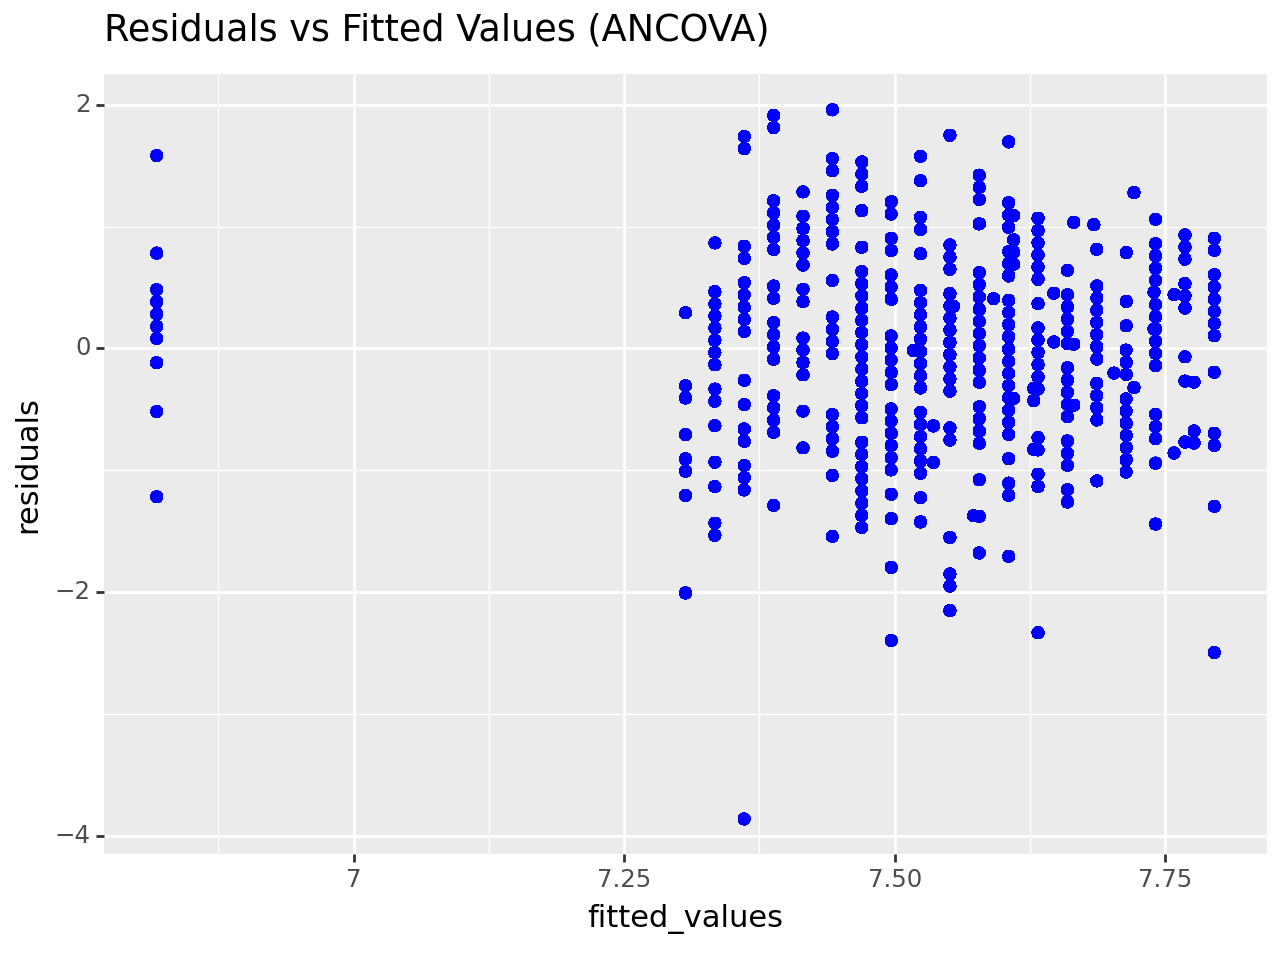

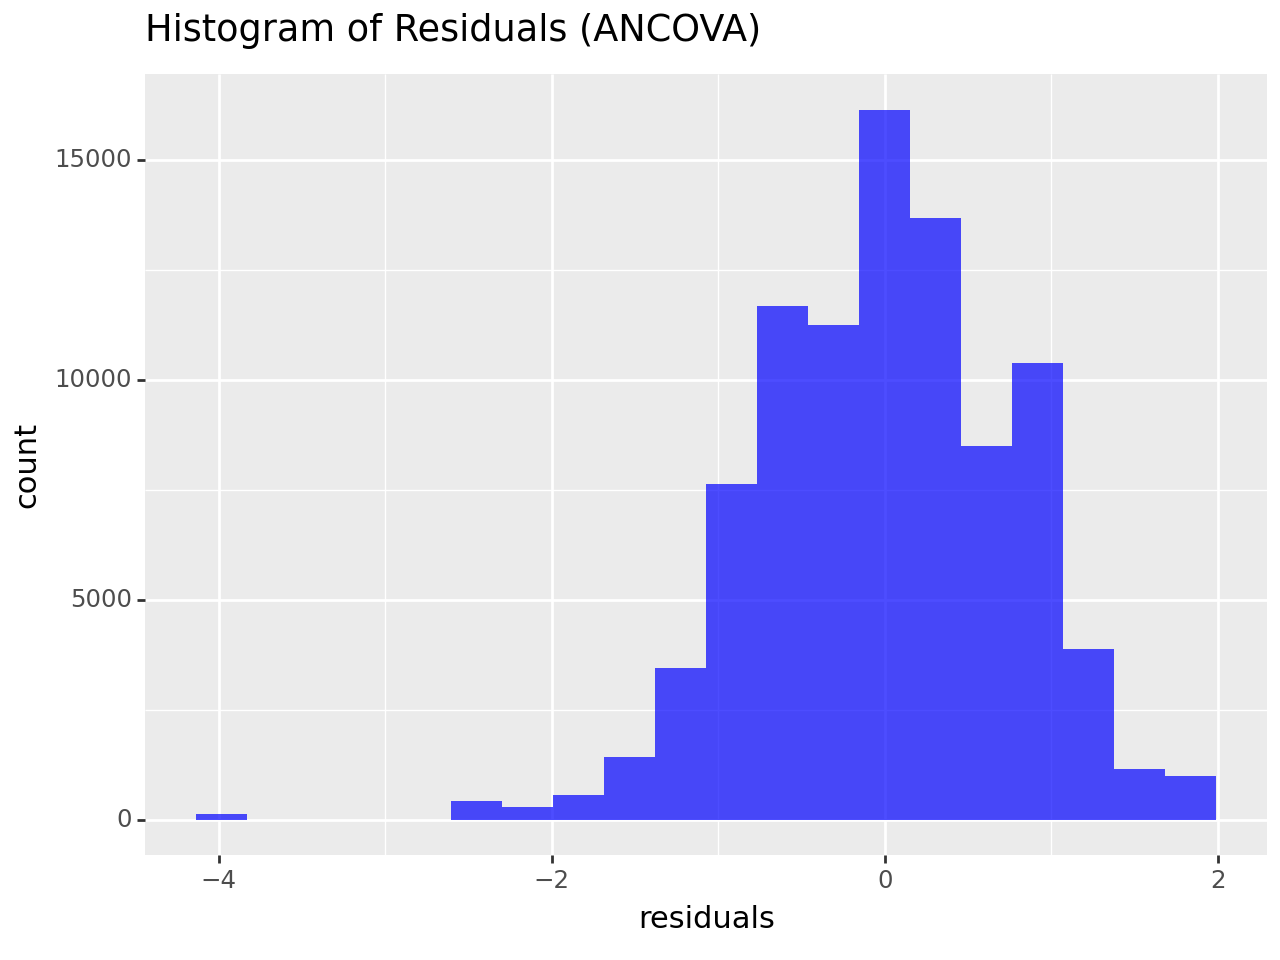

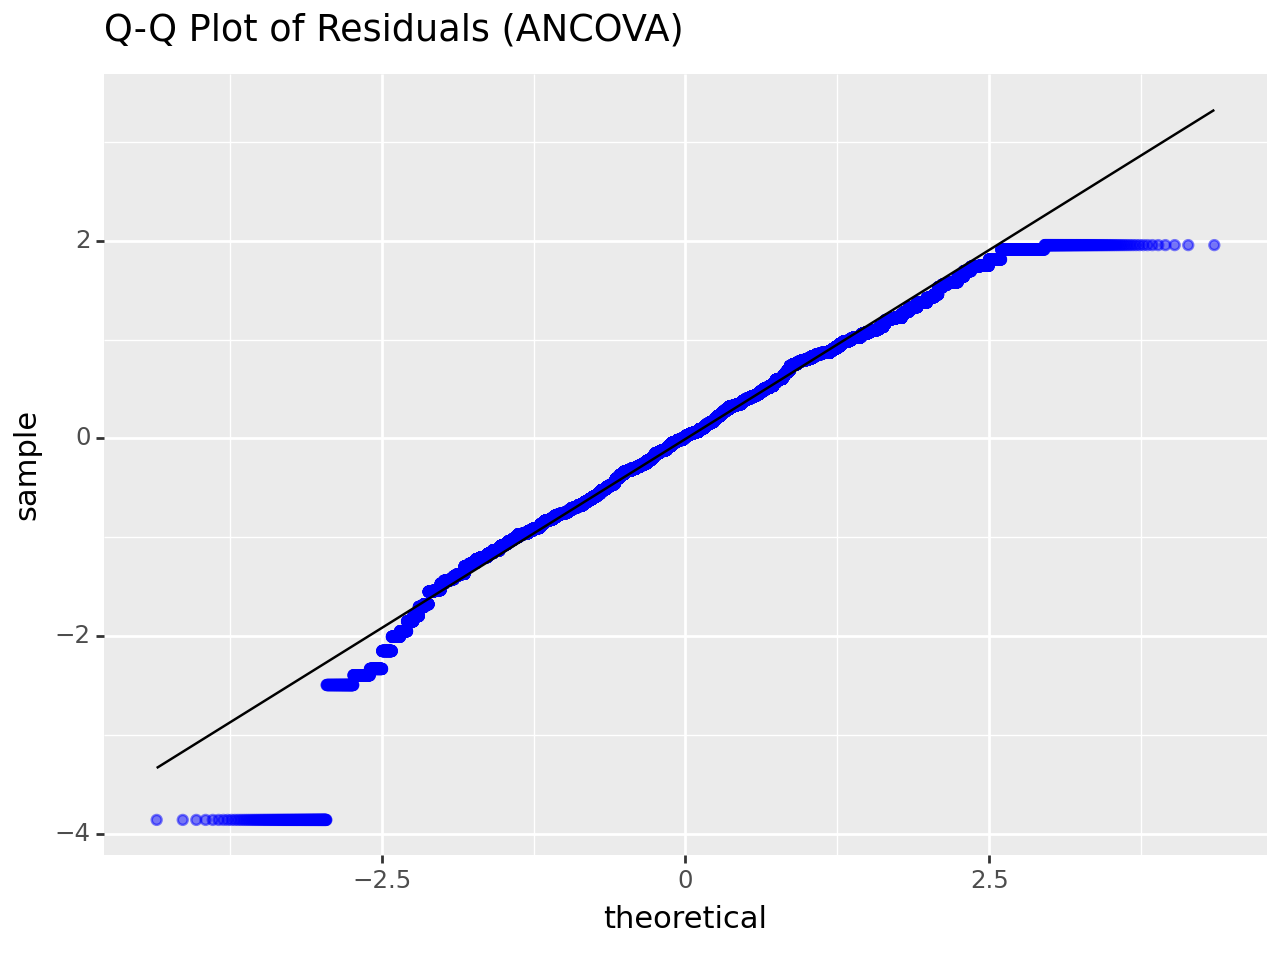

In [66]:
# Convert 'Air.date' to a numerical format (e.g., year)
filtered_star_trek_data['Air.date'] = pd.to_datetime(filtered_star_trek_data['Air.date'], errors='coerce')
filtered_star_trek_data['Year'] = filtered_star_trek_data['Air.date'].dt.year

# Fit the ANCOVA model with IMDB rating as the dependent variable, Female Director and Year as independent variables
ancova_model = ols('IMDB_Rating ~ C(Female_Director) * Year', data=filtered_star_trek_data).fit()

# Get the ANCOVA table
ancova_results = sm.stats.anova_lm(ancova_model, typ=2)
print(ancova_results)

# Diagnostic plots
df_fit_ancova = pd.DataFrame({
    'fitted_values': ancova_model.fittedvalues,
    'residuals': ancova_model.resid
})

# Residual plot
residual_plot_ancova = (ggplot(df_fit_ancova, aes(x='fitted_values', y='residuals')) +
                        geom_point(color='blue') +
                        ggtitle('Residuals vs Fitted Values (ANCOVA)'))

# Histogram of residuals
histogram_plot_ancova = (ggplot(df_fit_ancova, aes(x='residuals')) +
                         geom_histogram(bins=20, fill='blue', alpha=0.7) +
                         ggtitle('Histogram of Residuals (ANCOVA)'))

# Q-Q plot
qq_plot_ancova = (ggplot(df_fit_ancova, aes(sample='residuals')) +
                  geom_qq(color='blue', alpha=0.5) +
                  geom_qq_line() +
                  ggtitle('Q-Q Plot of Residuals (ANCOVA)'))

# Show the plots
print(residual_plot_ancova)
print(histogram_plot_ancova)
print(qq_plot_ancova)

Answer

The ANCOVA results show that both having a female director and the year an episode aired significantly affect IMDb ratings. The interaction between these two factors is also important, meaning the impact of having a female director changes over time. The diagnostic plots suggest that the residuals are mostly normal, though there’s a slight skew, indicating a few episodes with unusually low ratings. The residuals vs. fitted values plot shows some clustering, suggesting potential non-linearity or other factors that haven’t been accounted for.

2. Comment on the results. Is there an interaction between Female Director and Air date? Why do you think this is?

Answer

Yes, there's an interaction between Female Director and Air Date, meaning the effect of a female director on IMDb ratings changes depending on when the episode aired. This could be due to change in societal attitudes and the growing representation of women in media. Female-directed episodes were likely rarer and viewed differently in earlier years, while more recent episodes may have been more appreciated. This shift likely explains the significant interaction in the results.

## Question 6

Fit a logistic regression model for passing the Bechdel Wallace Test, considering the independent variables of Female Writer, Female Director, and Female Executive Producer.

1. Discuss the model results.

In [71]:
# Convert the Bechdel_Wallace_Test column to binary numeric (1 for True, 0 for False)
filtered_star_trek_data['Bechdel_Wallace_Test'] = filtered_star_trek_data['Bechdel_Wallace_Test'].astype(int)

# Now fit the logistic regression model
logistic_model = logit('Bechdel_Wallace_Test ~ C(Female_Writer) + C(Female_Director) + C(Female_Executive_Producer)', 
                       data=filtered_star_trek_data).fit()

# Print the summary of the logistic regression model
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.673392
         Iterations 5
                            Logit Regression Results                            
Dep. Variable:     Bechdel_Wallace_Test   No. Observations:                91584
Model:                            Logit   Df Residuals:                    91580
Method:                             MLE   Df Model:                            3
Date:                  Mon, 16 Sep 2024   Pseudo R-squ.:                 0.01356
Time:                          04:09:48   Log-Likelihood:                -61672.
converged:                         True   LL-Null:                       -62520.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               

discussion

The results show that having a female writer slightly decreases the chances of passing the Bechdel-Wallace Test, and this effect is statistically significant. However, the presence of a female director or female executive producer doesn’t have a significant impact, though there’s a positive trend with female executive producers. Overall, the model suggests that female involvement in writing, directing, or producing doesn’t strongly predict whether an episode passes the test, with only female writers showing a notable effect.

2. Now add Air.date in years to the model and compare results.

In [73]:
# Ensure the 'Year' column is properly formatted from 'Air.date'
filtered_star_trek_data['Year'] = pd.to_datetime(filtered_star_trek_data['Air.date'], errors='coerce').dt.year

# Fit the logistic regression model including Year
logistic_model_with_year = logit('Bechdel_Wallace_Test ~ C(Female_Writer) + C(Female_Director) + C(Female_Executive_Producer) + Year', 
                                 data=filtered_star_trek_data).fit()

# Print the summary of the new logistic regression model
print(logistic_model_with_year.summary())

Optimization terminated successfully.
         Current function value: 0.670633
         Iterations 5
                            Logit Regression Results                            
Dep. Variable:     Bechdel_Wallace_Test   No. Observations:                91584
Model:                            Logit   Df Residuals:                    91579
Method:                             MLE   Df Model:                            4
Date:                  Mon, 16 Sep 2024   Pseudo R-squ.:                 0.01760
Time:                          04:12:13   Log-Likelihood:                -61419.
converged:                         True   LL-Null:                       -62520.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              -

Discussion

With Year added to the model, there’s a noticeable shift in the results. Having a female writer is no longer a big factor (p-value = 0.785), with a small positive effect (coefficient = 0.092), meaning it doesn’t really change the chances of passing the Bechdel-Wallace Test. Similarly, female directors don’t have much impact either (p-value = 0.236), with a near-zero coefficient (-0.035). But the real standout is the effect of a female executive producer, which remains strong and significant (coefficient = 1.09, p-value < 0.001). Episodes with female executive producers are much more likely to pass the test. The biggest change comes with Year. The positive and highly significant effect (coefficient = 0.027, p-value < 0.001) shows that episodes have become more likely to pass the test as time goes on. This points to societal progress over the years, making Year a key factor in predicting whether an episode passes the Bechdel-Wallace Test.

this could be  suggest that adding the year to the model highlights how societal shifts over time have increased the likelihood of episodes passing the Bechdel-Wallace Test, with female executive producers also playing a strong role. The influence of female writers and directors seems to be less important once we account for when the episode was made.